In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Conv2D, Activation, BatchNormalization, Add , MaxPooling2D,GlobalAveragePooling2D, Dense , Flatten
from keras.optimizers import Adam
from keras import backend as K

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import *
from keras import initializers
from keras.layers import BatchNormalization

from sklearn.model_selection import train_test_split

In [ ]:

print("Start load train set")
# Load and preprocess training data
imgs_train = np.load('/content/drive/MyDrive/LUNA16/trainImages.npy').astype(np.float16)
imgs_mask_train = np.load('/content/drive/MyDrive/LUNA16/trainMasks.npy').astype(np.float16)
print("Finish load train set")

print("Start tranpose train set")
imgs_train = imgs_train.transpose(0, 2, 3, 1)
imgs_mask_train = imgs_mask_train.transpose(0, 2, 3, 1)
imgs_mask_train[imgs_mask_train > 0.] = 1.0
print("Finish tranpose load train set")


In [ ]:
print("Train img shape : ",imgs_train.shape)
print("Train mask shape : ",imgs_mask_train.shape)



In [ ]:

# Split the training data into training and validation sets
imgs_train, val_images, imgs_mask_train, val_masks = train_test_split(imgs_train, imgs_mask_train, test_size=0.2, random_state=42)

print("Train img shape:", imgs_train.shape)
print("Train mask shape:", imgs_mask_train.shape)
print("Validation img shape:", val_images.shape)
print("Validation mask shape:", val_masks.shape)

In [ ]:



# num_positive_pixels_train = np.sum(imgs_mask_train == 1)
# num_negative_pixels_train = np.sum(imgs_mask_train == 0)
# print("Num positive pixel" ,num_positive_pixels_train)
# print("Num negative pixel" ,num_negative_pixels_train)

# total_samples = num_negative_pixels_train + num_positive_pixels_train
# print("total / num ")
# print("0 : " , total_samples/num_negative_pixels_train)
# print("1 : " , total_samples / num_positive_pixels_train)

# print("num / total ")
# print("0 : " , num_negative_pixels_train/total_samples)
# print("1 : " , num_positive_pixels_train/total_samples)


# class_weights = np.array([ 0.9740243197407962 , 0.02597568025920382 ])
# class_weights =  np.array([0.02597568, 0.97402432])
# total_samples = 14109012 + 529053356
# num_classes = 2
# class_samples_positive = 14109012
# class_samples_negative = 529053356

# class_weight_positive = total_samples / (num_classes * class_samples_positive)
# class_weight_negative = total_samples / (num_classes * class_samples_negative)

# print("Class Weight for Positive Class 0 :", class_weight_positive)
# print("Class Weight for Negative Class 1 :", class_weight_negative)

# class_weights = np.array([ class_weight_negative , class_weight_positive ])

# Try this

class_weights =  np.array([0.02, 1.2])
print("Class Weights:", class_weights)

In [ ]:
def data_generator(imgs, masks, batch_size=1):
    num_samples = len(imgs)
    while True:
        indices = np.random.choice(num_samples, batch_size, replace=False)
        batch_imgs = imgs[indices]
        batch_masks = masks[indices]
        yield batch_imgs, batch_masks


In [ ]:
# Renormalizing the masks
imgs_mask_train[imgs_mask_train > 0.] = 1.0



In [ ]:
import tensorflow as tf
from keras.layers import Input, Conv2D, BatchNormalization, Activation, Dense, AveragePooling2D
from keras.models import Model

def Bottleneck(x, growth_rate):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(4 * growth_rate, kernel_size=1, padding='same', use_bias=False)(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(growth_rate, kernel_size=3, padding='same', use_bias=False)(x)

    return x

def Transition(x, out_planes):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(out_planes, kernel_size=1, padding='same', use_bias=False)(x)

    return x

def DenseNet(blocks, growth_rate=12, reduction=0.5, num_classes=1):
    num_planes = 2 * growth_rate
    input_tensor = Input(shape=(512, 512, 1))
    x = Conv2D(num_planes, kernel_size=3, padding='same', use_bias=False)(input_tensor)

    dense_blocks = []
    for nblock in blocks:
        for _ in range(nblock):
            x = Bottleneck(x, growth_rate)
            dense_blocks.append(x)
            num_planes += growth_rate

        if reduction is not None:
            num_planes = int(num_planes * reduction)
            x = Transition(x, num_planes)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Adjusted the final Conv2D layer to output 1 channel
    x = Conv2D(num_classes, kernel_size=1, activation='sigmoid')(x)

    model = Model(inputs=input_tensor, outputs=x)
    model.summary()
    return model

def densenet_custom():
    return DenseNet([2, 3, 4], growth_rate=8)

# Test the model
def test_densenet():
    net = densenet_custom()
    x = tf.random.normal((1, 512, 512, 1))
    y = net(x)
    print(y.shape)

# Call the test function
test_densenet()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 512, 512, 16)      144       
                                                                 
 batch_normalization (BatchN  (None, 512, 512, 16)     64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 512, 512, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 512, 512, 32)      512       
                                                                 
 batch_normalization_1 (Batc  (None, 512, 512, 32)     128       
 hNormalization)                                             

In [ ]:

def dice_coef_loss(y_true, y_pred):
    return 1. - dice_coef(y_true, y_pred)
def dice_coefficient(y_true, y_pred):
    smooth = 1.0

    # Flatten the true and predicted masks
    y_true_flat = tf.keras.backend.flatten(y_true)
    y_pred_flat = tf.keras.backend.flatten(y_pred)

    intersection = tf.keras.backend.sum(y_true_flat * y_pred_flat)
    dice_coeff_class_0 = (2.0 * intersection + smooth) / (tf.keras.backend.sum(y_true_flat) + tf.keras.backend.sum(y_pred_flat) + smooth)

    y_true_class_1 = 1 - y_true
    y_pred_class_1 = 1 - y_pred

    y_true_flat_class_1 = tf.keras.backend.flatten(y_true_class_1)
    y_pred_flat_class_1 = tf.keras.backend.flatten(y_pred_class_1)

    intersection_class_1 = tf.keras.backend.sum(y_true_flat_class_1 * y_pred_flat_class_1)
    dice_coeff_class_1 = (2.0 * intersection_class_1 + smooth) / (tf.keras.backend.sum(y_true_flat_class_1) + tf.keras.backend.sum(y_pred_flat_class_1) + smooth)

    # Calculate the mean of both Dice coefficients
    dice_coefficient = (dice_coeff_class_0 + dice_coeff_class_1) / 2.0
    return dice_coefficient

def dice_coef(y_true, y_pred):
    smooth = 1.0
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)

# def weighted_dice_coef_loss(y_true, y_pred):
#     return 1.0 - dice_coef(y_true, y_pred)


def weighted_dice_coef_loss(class_weights):
    def loss(y_true, y_pred):
        # Calculate the Dice coefficient
        dice_coeff = dice_coef(y_true, y_pred)

        # Apply class weights to the Dice coefficient
        weighted_dice_loss = (1.0 - dice_coeff) * class_weights

        return weighted_dice_loss
    return loss

In [ ]:

epochs = 60

print("Train img shape : ",imgs_train.shape)
print("Train mask shape : ",imgs_mask_train.shape)


print('Creating and compiling model...')
model = densenet_custom()
model.compile(optimizer= Adam(learning_rate=0.005), loss=weighted_dice_coef_loss(class_weights), metrics=['accuracy',dice_coefficient])
# model.compile(optimizer='adam', loss=weighted_dice_coef_loss, metrics=['accuracy', dice_coefficient])

# Define model checkpoints
filepath = "/content/drive/MyDrive/LUNA16/DensenetModel.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_dice_coefficient', verbose=1, save_best_only=True, mode='max', save_weights_only=True)

print('Generate data...... ')

# Use generator for training data to reduce memory usage
train_generator = data_generator(imgs_train, imgs_mask_train, batch_size=12)
steps_per_epoch = len(imgs_train) / 12
validation_data = (val_images, val_masks)

# Set mixed-precision policy if supported by GPU
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)


print("Train img shape : ",imgs_train.shape)
print("Train mask shape : ",imgs_mask_train.shape)

print('Fitting model...')
# Train the model
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs = epochs, validation_data=validation_data, callbacks=[checkpoint])


Train img shape :  (2072, 512, 512, 1)
Train mask shape :  (2072, 512, 512, 1)
Creating and compiling model...
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512, 512, 1)]     0         
                                                                 
 conv2d_23 (Conv2D)          (None, 512, 512, 16)      144       
                                                                 
 batch_normalization_22 (Bat  (None, 512, 512, 16)     64        
 chNormalization)                                                
                                                                 
 activation_22 (Activation)  (None, 512, 512, 16)      0         
                                                                 
 conv2d_24 (Conv2D)          (None, 512, 512, 32)      512       
                                                                 
 batch_normali

In [ ]:
print("Start load test set")
# Load and preprocess test data
imgs_test = np.load('/content/drive/MyDrive/LUNA16/testImages.npy').astype(np.float16)
imgs_mask_test_true = np.load('/content/drive/MyDrive/LUNA16/testMasks.npy').astype(np.float16)
print("Finish load test set")


print("Start tranpose load test set")
imgs_test = imgs_test.transpose(0, 2, 3, 1)
imgs_mask_test_true = imgs_mask_test_true.transpose(0, 2, 3, 1)
imgs_mask_test_true[imgs_mask_test_true > 0] = 1.0
print("Finish tranpose load test set")

Start load test set
Finish load test set
Start tranpose load test set
Finish tranpose load test set


In [ ]:

# Load the model architecture and create the model object (if needed)
# Assuming you have defined the model architecture somewhere
model = densenet_custom()
model.compile(optimizer= Adam(learning_rate=0.005), loss=weighted_dice_coef_loss(class_weights), metrics=['accuracy',dice_coefficient])

# Specify the path to the HDF5 file containing the saved model weights
weights_path = "/content/drive/MyDrive/LUNA16/DensenetModel.hdf5"

# Load the model weights from the HDF5 file
model.load_weights(weights_path)

print("Done")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512, 512, 1)]     0         
                                                                 
 conv2d_23 (Conv2D)          (None, 512, 512, 16)      144       
                                                                 
 batch_normalization_22 (Bat  (None, 512, 512, 16)     64        
 chNormalization)                                                
                                                                 
 activation_22 (Activation)  (None, 512, 512, 16)      0         
                                                                 
 conv2d_24 (Conv2D)          (None, 512, 512, 32)      512       
                                                                 
 batch_normalization_23 (Bat  (None, 512, 512, 32)     128       
 chNormalization)                                          

In [ ]:
from skimage.measure import label, regionprops
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from datetime import datetime
import pytz

# Specify the Malaysia time zone
malaysia_time_zone = pytz.timezone('Asia/Kuala_Lumpur')

y_pred = model.predict(imgs_test)
y_pred_binary = (y_pred > 0.5).astype(np.float16)

print("Y_pred_binary : ", y_pred_binary.shape)
# Define your min and max size thresholds
min_size = 600
max_size = 10201

# Initialize an array for filtered binary predictions
filtered_pred_binary = np.zeros_like(y_pred_binary)

for i in range(len(y_pred_binary)):
    labeled_regions = label(y_pred_binary[i])

    region_props = regionprops(labeled_regions)
    for region in region_props:
        region_area = region.area
        if min_size <= region_area <= max_size:
            filtered_pred_binary[i][labeled_regions == region.label] = 1
print("filtered_pred_binary : ", filtered_pred_binary.shape)
print("Generating report ... ")


start_time = datetime.now(malaysia_time_zone)
start_formatted_time = start_time.strftime("%I:%M %p")
print("Start time : ", start_formatted_time)
# Evaluate the filtered predictions using appropriate metrics
filtered_classification_rep = classification_report(imgs_mask_test_true.flatten(), filtered_pred_binary.flatten())
end_time = datetime.now(malaysia_time_zone)
end_formatted_time = end_time.strftime("%I:%M %p")
print("End time : " , end_formatted_time)
# Print the metrics for filtered predictions
print("Filtered Classification Report:")
print(filtered_classification_rep)

21/21 [==============================] - 16s 561ms/step
Y_pred_binary :  (647, 512, 512, 1)
filtered_pred_binary :  (647, 512, 512, 1)
Generating report ... 
Start time :  03:52 PM
End time :  04:28 PM
Filtered Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99 165203890
         1.0       0.64      0.25      0.36   4403278

    accuracy                           0.98 169607168
   macro avg       0.81      0.62      0.67 169607168
weighted avg       0.97      0.98      0.97 169607168



In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy = accuracy_score(imgs_mask_test_true.flatten(), filtered_pred_binary.flatten())
accuracy_percentage = accuracy * 100  # Convert accuracy to percentage

# Format and print the accuracy as a percentage with two decimal places
formatted_accuracy = "{:.2f}".format(accuracy_percentage)
print("Accuracy:", formatted_accuracy, "%")


Accuracy: 97.68 %


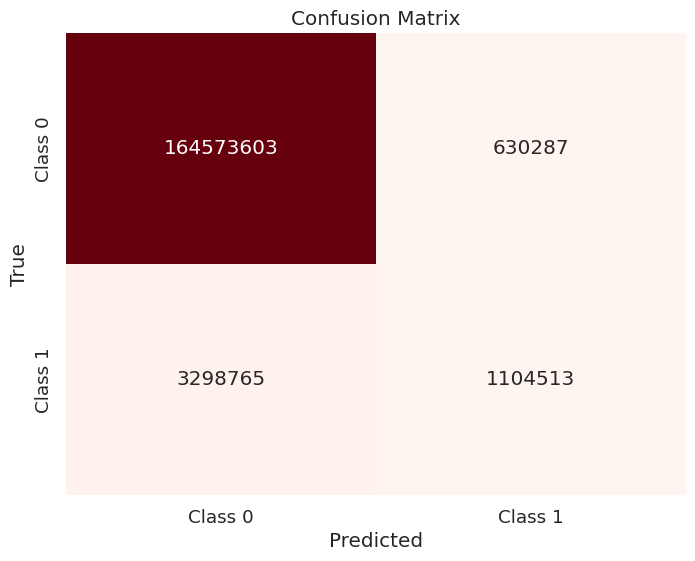

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Calculate the confusion matrix
# confusion = confusion_matrix(imgs_mask_test_true.flatten(), filtered_pred_binary.flatten())

# Plot the confusion matrix as a heatmap with a red color scheme
# Plot the confusion matrix as a heatmap with the RdBu colormap
# Define custom colors for annotations
colors = [ "skyblue", "blue"]
cmap = sns.color_palette(colors)

# Plot the confusion matrix as a heatmap with custom colors
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Reds", cbar=False,
            xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

